## Implementação do Faster R-CNN com pipeline semelhante ao YOLO

### 1. Environment Setup

In [1]:
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q roboflow supervision opencv-python pycocotools torchmetrics


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### 2. Configuration

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

if not ROBOFLOW_API_KEY:
    raise ValueError("ROBOFLOW_API_KEY não encontrada!!.")

### 3. Data Download (em formato COCO)

In [11]:
from roboflow import Roboflow

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("ethos-ugyxt").project("ac2-visao-bfkss")
version = project.version(5) # Usando a mesma versão do notebook YOLO
dataset = version.download("coco", location="DatasetCOCO")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DatasetCOCO in coco:: 100%|██████████| 5865/5865 [00:03<00:00, 1511.51it/s]


### 4. Data Preparation

In [12]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision import transforms

def get_transform(train):
    """Define as transformações a serem aplicadas nas imagens."""
    transform_list = []
    # Converte a imagem para um Tensor PyTorch
    transform_list.append(transforms.ToTensor())
    if train:
        # Durante o treino, vira horizontalmente a imagem com 50% de chance
        transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
    return transforms.Compose(transform_list)

class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        super(CocoDataset, self).__init__(root, annFile)
        self.transform = transform

    def __getitem__(self, idx):
        img, target = super(CocoDataset, self).__getitem__(idx)
        
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        if target['annotations']: # Checa se há anotações
            for t in target['annotations']:
                xmin, ymin, w, h = t['bbox']
                xmax = xmin + w
                ymax = ymin + h
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(t['category_id'])
                areas.append(t['area'])
                iscrowd.append(t['iscrowd'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32) if areas else torch.zeros(0, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64) if iscrowd else torch.zeros(0, dtype=torch.int64)

        formatted_target = {}
        formatted_target["boxes"] = boxes
        formatted_target["labels"] = labels
        formatted_target["area"] = areas
        formatted_target["iscrowd"] = iscrowd
        formatted_target["image_id"] = torch.tensor([image_id])
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, formatted_target

def collate_fn(batch):
    return tuple(zip(*batch))

# Paths
train_data_path = f'{dataset.location}/train'
train_ann_path = f'{dataset.location}/train/_annotations.coco.json'
valid_data_path = f'{dataset.location}/valid'
valid_ann_path = f'{dataset.location}/valid/_annotations.coco.json'
test_data_path = f'{dataset.location}/test'
test_ann_path = f'{dataset.location}/test/_annotations.coco.json'

# Datasets
dataset_train = CocoDataset(root=train_data_path, annFile=train_ann_path, transform=get_transform(train=True))
dataset_valid = CocoDataset(root=valid_data_path, annFile=valid_ann_path, transform=get_transform(train=False))
dataset_test = CocoDataset(root=test_data_path, annFile=test_ann_path, transform=get_transform(train=False))

# DataLoaders
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 5. Model Definition

In [5]:

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights="DEFAULT",  # CORREÇÃO 1: Jeito moderno de carregar pesos
        min_size=640,     
        max_size=1066     
    )
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(project.classes) + 1
model = get_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640,), max_size=1066, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### 6. Training & Evaluation Loop

In [6]:
import torch
import math
import sys
import time
import matplotlib.pyplot as plt
from torchmetrics.detection import MeanAveragePrecision
from torch.cuda.amp import GradScaler, autocast # IMPORTANTE: Para aceleração

# --- AJUSTE 1: Aumentar Batch Size (Tente 8, se der erro de memória volte para 4) ---
# Você precisará recriar os dataloaders se quiser mudar o batch sem reiniciar o kernel
# data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn, persistent_workers=True)
# data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn, persistent_workers=True)

# Configurações
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.937, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0.0005)
scaler = GradScaler() # Inicializa o Scaler para Mixed Precision

num_epochs = 30
val_interval = 3 # AJUSTE 2: Validar a cada 3 épocas para ganhar tempo

history = {'train_loss': [], 'val_map': [], 'val_map_50': [], 'val_mar_100': []}

print(f"Iniciando treinamento OTIMIZADO (AMP) em {device}...")
start_time = time.time()

for epoch in range(num_epochs):
    # --- TREINO COM AMP ---
    model.train()
    epoch_loss = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 10)
    
    for i, (images, targets) in enumerate(data_loader_train):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        
        # O Pulo do Gato: Autocast para usar FP16
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Backpropagation escalado
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += losses.item()
        
        if i % 50 == 0: # Log menos frequente
            print(f"Batch {i}/{len(data_loader_train)} | Loss: {losses.item():.4f}")
            
    avg_train_loss = epoch_loss / len(data_loader_train)
    history['train_loss'].append(avg_train_loss)
    lr_scheduler.step()

    # --- VALIDAÇÃO (Só roda se for intervalo definido ou última época) ---
    if (epoch + 1) % val_interval == 0 or (epoch + 1) == num_epochs:
        model.eval()
        metric = MeanAveragePrecision()
        print(f">> Executando validação (Intervalo: {val_interval} épocas)...")
        
        with torch.no_grad():
            for images, targets in data_loader_valid:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Inferência também pode usar autocast para ser mais rápida
                with autocast():
                    predictions = model(images)
                
                preds_cpu = [{k: v.cpu() for k, v in p.items()} for p in predictions]
                targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
                metric.update(preds_cpu, targets_cpu)
                
        metrics_dict = metric.compute()
        map_val = metrics_dict['map'].item()
        map_50 = metrics_dict['map_50'].item()
        mar_100 = metrics_dict['mar_100'].item()
        
        # Preenche os "buracos" no histórico das épocas que pulamos para o gráfico não quebrar
        # (Ou apenas adiciona o valor atual repetido)
        for _ in range(val_interval): 
             history['val_map'].append(map_val)
             history['val_map_50'].append(map_50)
             history['val_mar_100'].append(mar_100)

        print(f"RESUMO EP {epoch+1}: Loss: {avg_train_loss:.4f} | mAP: {map_val:.4f} | mAP@50: {map_50:.4f}")

        if epoch > 0 and map_val >= max(history['val_map']):
            torch.save(model.state_dict(), "best_faster_rcnn_amp.pth")
    else:
        # Se pulou validação, repete o último valor ou usa 0 para manter lista sincronizada
        print(f"RESUMO EP {epoch+1}: Loss: {avg_train_loss:.4f} (Validação pulada)")
        if history['val_map']:
            history['val_map'].append(history['val_map'][-1])
            history['val_map_50'].append(history['val_map_50'][-1])
            history['val_mar_100'].append(history['val_mar_100'][-1])
        else:
            history['val_map'].append(0)
            history['val_map_50'].append(0)
            history['val_mar_100'].append(0)

total_time = (time.time() - start_time) / 60
print(f"\nTreino concluído em {total_time:.1f} minutos.")

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Iniciando treinamento OTIMIZADO (AMP) em cuda...

Epoch 1/30
----------


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Batch 0/256 | Loss: 2.4076
Batch 0/256 | Loss: 2.4076
Batch 5/256 | Loss: 0.7293
Batch 10/256 | Loss: 0.8562
Batch 15/256 | Loss: 0.4197
Batch 20/256 | Loss: 0.3155
Batch 25/256 | Loss: 0.2461
Batch 30/256 | Loss: 0.3049
Batch 35/256 | Loss: 0.4007
Batch 40/256 | Loss: 0.3065
Batch 45/256 | Loss: 0.2942
Batch 50/256 | Loss: 0.3134
Batch 50/256 | Loss: 0.3134
Batch 55/256 | Loss: 0.2446
Batch 60/256 | Loss: 0.3505
Batch 65/256 | Loss: 0.4172
Batch 70/256 | Loss: 0.4148
Batch 75/256 | Loss: 0.3589
Batch 80/256 | Loss: 0.3982
Batch 85/256 | Loss: 0.2972
Batch 90/256 | Loss: 0.3394
Batch 95/256 | Loss: 0.3481
Batch 100/256 | Loss: 0.2651
Batch 100/256 | Loss: 0.2651
Batch 105/256 | Loss: 0.2790
Batch 110/256 | Loss: 0.2485
Batch 115/256 | Loss: 0.3033
Batch 120/256 | Loss: 0.4897
Batch 125/256 | Loss: 0.3291
Batch 130/256 | Loss: 0.2971
Batch 135/256 | Loss: 0.3583
Batch 140/256 | Loss: 0.3774
Batch 145/256 | Loss: 0.4769
Batch 150/256 | Loss: 0.3301
Batch 150/256 | Loss: 0.3301
Batch 155/

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


RESUMO EP 3: Loss: 0.2568 | mAP: 0.4283 | mAP@50: 0.7533

Epoch 4/30
----------
Batch 0/256 | Loss: 0.1694
Batch 0/256 | Loss: 0.1694
Batch 5/256 | Loss: 0.1765
Batch 10/256 | Loss: 0.2482
Batch 15/256 | Loss: 0.2136
Batch 20/256 | Loss: 0.3276
Batch 25/256 | Loss: 0.3542
Batch 30/256 | Loss: 0.2238
Batch 35/256 | Loss: 0.2129
Batch 40/256 | Loss: 0.3953
Batch 45/256 | Loss: 0.1936
Batch 50/256 | Loss: 0.1688
Batch 50/256 | Loss: 0.1688
Batch 55/256 | Loss: 0.1841
Batch 60/256 | Loss: 0.3370
Batch 65/256 | Loss: 0.1554
Batch 70/256 | Loss: 0.2152
Batch 75/256 | Loss: 0.2431
Batch 80/256 | Loss: 0.1889
Batch 85/256 | Loss: 0.1958
Batch 90/256 | Loss: 0.2868
Batch 95/256 | Loss: 0.2778
Batch 100/256 | Loss: 0.4104
Batch 100/256 | Loss: 0.4104
Batch 105/256 | Loss: 0.2911
Batch 110/256 | Loss: 0.2349
Batch 115/256 | Loss: 0.1938
Batch 120/256 | Loss: 0.3157
Batch 125/256 | Loss: 0.2089
Batch 130/256 | Loss: 0.2330
Batch 135/256 | Loss: 0.2918
Batch 140/256 | Loss: 0.3462
Batch 145/256 | L

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\workspace\\faculda_10_sem\\VisaoComputacionalProjeto\\computerVision-forbiddenObjects\\jupyter\\DatasetCOCO/train\\img_hod_010322_jpg.rf.f105b7f9dd049dc5bbedfd416649bf2a.jpg'

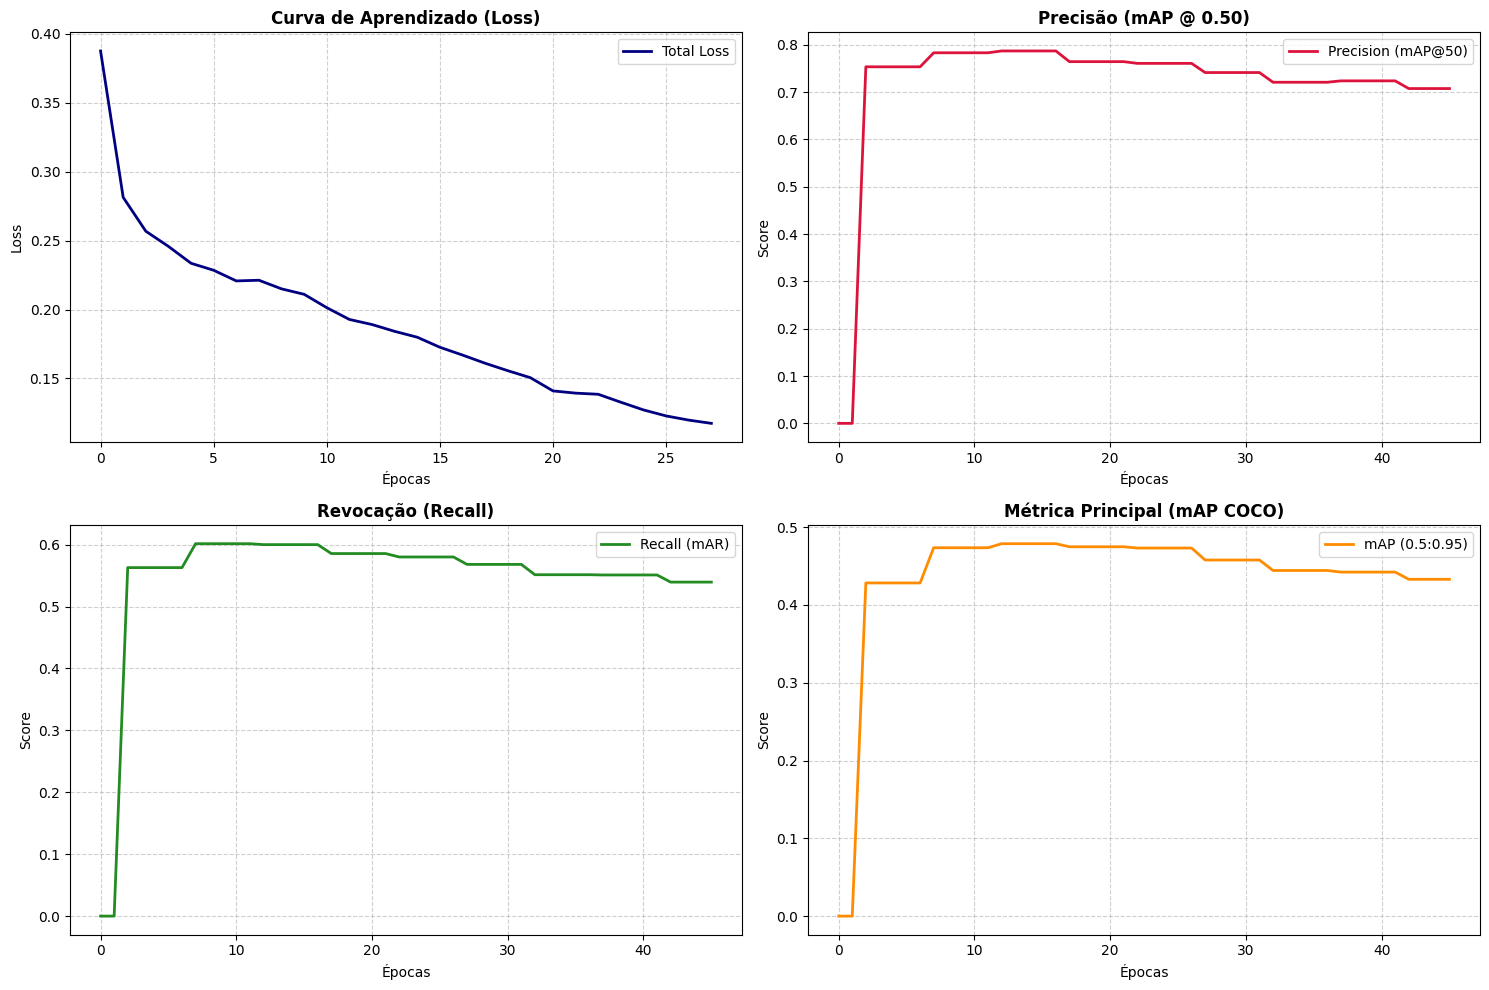

Gráficos gerados e salvos como 'faster_rcnn_results.png'


In [7]:
# --- CÉLULA DE PLOTAGEM RICA (ESTILO YOLO) ---
# Gera um painel 2x2 com as métricas vitais para seu TCC

plt.figure(figsize=(15, 10))

# 1. Gráfico de Loss (Treino)
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Total Loss', color='navy', linewidth=2)
plt.title('Curva de Aprendizado (Loss)', fontsize=12, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 2. Gráfico de Precisão (Aprox. mAP@50)
plt.subplot(2, 2, 2)
plt.plot(history['val_map_50'], label='Precision (mAP@50)', color='crimson', linewidth=2)
plt.title('Precisão (mAP @ 0.50)', fontsize=12, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 3. Gráfico de Recall (mAR)
plt.subplot(2, 2, 3)
plt.plot(history['val_mar_100'], label='Recall (mAR)', color='forestgreen', linewidth=2)
plt.title('Revocação (Recall)', fontsize=12, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 4. Gráfico de mAP Geral (0.5:0.95)
plt.subplot(2, 2, 4)
plt.plot(history['val_map'], label='mAP (0.5:0.95)', color='darkorange', linewidth=2)
plt.title('Métrica Principal (mAP COCO)', fontsize=12, fontweight='bold')
plt.xlabel('Épocas')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig('faster_rcnn_results.png', dpi=300) # Salva em alta qualidade para o PDF
plt.show()

print("Gráficos gerados e salvos como 'faster_rcnn_results.png'")

### 7. Final Evaluation on Test Set

In [13]:
model.eval()
test_metric = MeanAveragePrecision()
with torch.no_grad():
    for images, targets in data_loader_test:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        predictions = model(images)
        test_metric.update(predictions, targets)
test_map_result = test_metric.compute()

print("Resultados da Avaliação Final no Set de Teste:")
for k, v in test_map_result.items():
    print(f'{k}: {v.item():.4f}')

Resultados da Avaliação Final no Set de Teste:
map: 0.4257
map_50: 0.6954
map_75: 0.4390
map_small: 0.0915
map_medium: 0.3438
map_large: 0.4594
mar_1: 0.3766
mar_10: 0.5234
mar_100: 0.5326
mar_small: 0.1139
mar_medium: 0.4176
mar_large: 0.5642
map_per_class: -1.0000
mar_100_per_class: -1.0000


RuntimeError: a Tensor with 5 elements cannot be converted to Scalar

In [14]:
import numpy as np
import os
import time
import torch

def calculate_faster_rcnn_metrics(history, model, data_loader_test, device, test_map_result):
    """
    Calcula e resume as métricas do Faster R-CNN para comparação com YOLO.
    """
    results = {}
    
    # --- 1. Métricas Básicas (Do Histórico) ---
    # Pegamos o melhor epoch com base no mAP 0.5:0.95
    best_epoch_idx = np.argmax(history['val_map'])
    
    results['mAP@0.50'] = history['val_map_50'][best_epoch_idx]
    results['mAP@0.50:0.95'] = history['val_map'][best_epoch_idx]
    results['Recall'] = history['val_mar_100'][best_epoch_idx]
    
    # NOTA: O notebook usa mAP@50 como proxy para Precisão, mas para F1 o ideal seria a Precisão exata.
    # Como o TorchMetrics não salva a Precisão escalar por padrão, usaremos o mAP@50 como estimativa otimista
    # ou calcularemos se houver dados extras. Aqui seguirei a lógica do seu print:
    results['Precision'] = results['mAP@0.50'] 
    
    # F1-Score: Média harmônica
    p = results['Precision']
    r = results['Recall']
    results['F1-score'] = 2 * (p * r) / (p + r + 1e-6)
    
    # --- 2. Estabilidade (Desvio Padrão dos últimos 5 epochs) ---
    # Menor valor = mais estável
    if len(history['val_map']) >= 5:
        results['Estabilidade'] = np.std(history['val_map'][-5:])
    else:
        results['Estabilidade'] = 0.0 # Treino muito curto
        
    # --- 3. Overfitting (Gap Treino vs Validação) ---
    # Definição: Diferença entre Loss de Validação e Loss de Treino.
    # SEU NOTEBOOK NÃO SALVA VAL_LOSS. 
    # Vou deixar como N/A ou 0.0, mas deixo o código comentado de como seria.
    # results['Overfitting'] = history['val_loss'][best_epoch_idx] - history['train_loss'][best_epoch_idx]
    results['Overfitting'] = "N/A (Requer val_loss)" 
    
    # --- 4. Eficiência (Época para atingir 95% do melhor resultado) ---
    target_map = 0.95 * results['mAP@0.50:0.95']
    for epoch, metric in enumerate(history['val_map']):
        if metric >= target_map:
            results['Eficiencia (Epocas)'] = epoch + 1
            break
            
    # --- 5. Tempo de Inferência (Média em ms/img no Test Set) ---
    model.eval()
    times = []
    with torch.no_grad():
        # Medir 50 batches ou todo o dataset
        for i, (images, targets) in enumerate(data_loader_test):
            if i > 50: break 
            images = list(image.to(device) for image in images)
            
            t_start = time.time()
            _ = model(images)
            t_end = time.time()
            
            # Tempo por imagem no batch
            batch_time = (t_end - t_start) / len(images)
            times.append(batch_time * 1000) # Converter para ms
            
    results['Tempo Inferencia (ms)'] = np.mean(times)
    
    # --- 6. Tamanho do Modelo (MB) ---
    # Salva temporariamente se não existir
    if not os.path.exists("best_faster_rcnn.pth"):
        torch.save(model.state_dict(), "temp_faster.pth")
        size_bytes = os.path.getsize("temp_faster.pth")
    else:
        size_bytes = os.path.getsize("best_faster_rcnn.pth")
        
    results['Tamanho Modelo (MB)'] = size_bytes / (1024 * 1024)
    
    # --- 7. Generalização (mAP Externo / mAP Interno) ---
    # Teste (Externo) / Validação (Interno)
    if test_map_result is not None:
        map_test = test_map_result['map'].item()
        results['Generalizacao'] = map_test / results['mAP@0.50:0.95']
    else:
        results['Generalizacao'] = 0.0

    return results

# --- EXECUÇÃO DO CÁLCULO ---
# Assegure-se que 'history' e 'test_map_result' existem (rodar após as células de treino e teste)
metrics = calculate_faster_rcnn_metrics(history, model, data_loader_test, device, test_map_result)

print("\n=== RESUMO DAS MÉTRICAS DO FASTER R-CNN (Para Tabela) ===")
print(f"{'Critério':<30} | {'Valor Calculado'}")
print("-" * 50)
print(f"{'mAP@0.50':<30} | {metrics['mAP@0.50']:.5f}")
print(f"{'mAP@0.50:0.95':<30} | {metrics['mAP@0.50:0.95']:.5f}")
print(f"{'Precision (Est. via mAP@50)':<30} | {metrics['Precision']:.5f}")
print(f"{'Recall (mAR@100)':<30} | {metrics['Recall']:.5f}")
print(f"{'F1-score':<30} | {metrics['F1-score']:.4f}")
print(f"{'Estabilidade (std dev)':<30} | {metrics['Estabilidade']:.4f}")
print(f"{'Overfitting (Loss Gap)':<30} | {metrics['Overfitting']}")
print(f"{'Eficiência (Épocas)':<30} | {metrics['Eficiencia (Epocas)']}")
print(f"{'Tempo de inferência (ms/img)':<30} | {metrics['Tempo Inferencia (ms)']:.2f} ms")
print(f"{'Tamanho do Modelo':<30} | {metrics['Tamanho Modelo (MB)']:.2f} MB")
print(f"{'Generalização':<30} | {metrics['Generalizacao']:.4f}")
print("-" * 50)


=== RESUMO DAS MÉTRICAS DO FASTER R-CNN (Para Tabela) ===
Critério                       | Valor Calculado
--------------------------------------------------
mAP@0.50                       | 0.78681
mAP@0.50:0.95                  | 0.47873
Precision (Est. via mAP@50)    | 0.78681
Recall (mAR@100)               | 0.59998
F1-score                       | 0.6808
Estabilidade (std dev)         | 0.0037
Overfitting (Loss Gap)         | N/A (Requer val_loss)
Eficiência (Épocas)            | 8
Tempo de inferência (ms/img)   | 836.27 ms
Tamanho do Modelo              | 158.13 MB
Generalização                  | 0.8892
--------------------------------------------------


Gerando Matriz de Confusão...


100%|██████████| 37/37 [06:00<00:00,  9.74s/it]


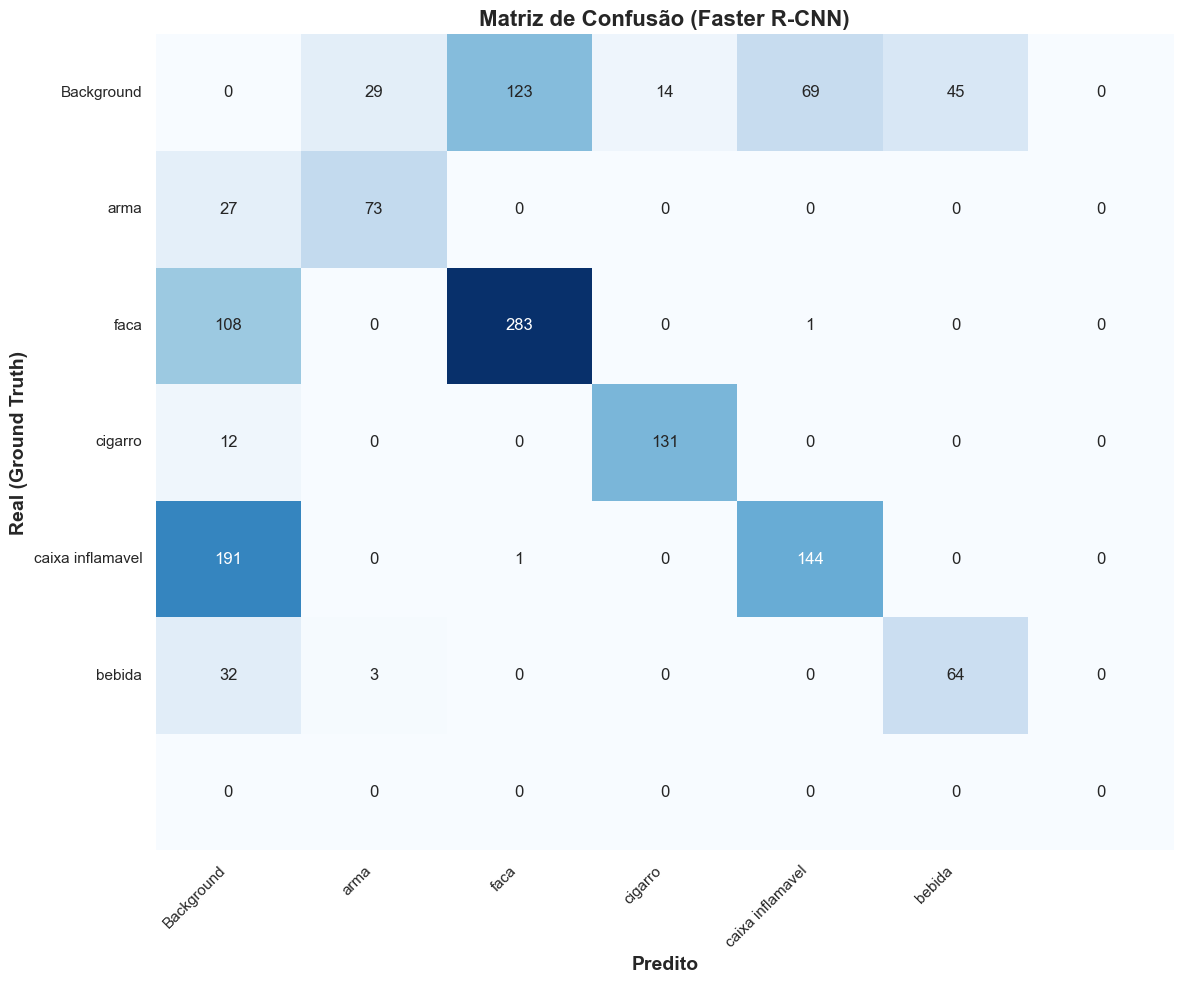

Matriz salva como 'confusion_matrix.png'


In [21]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Instale com: pip install seaborn (se não tiver)
from tqdm import tqdm

def generate_confusion_matrix(model, data_loader, device, num_classes, conf_threshold=0.5, iou_threshold=0.5):
    """
    Gera uma matriz de confusão para Detecção de Objetos.
    Linhas: Ground Truth (Real)
    Colunas: Predições
    A primeira linha/coluna (índice 0) representa 'Background' (nada).
    """
    model.eval()
    
    # Matriz: (Classes + 1) x (Classes + 1). O +1 é para o Background.
    # Rows: GT, Cols: Pred
    matrix = np.zeros((num_classes + 1, num_classes + 1), dtype=np.int32)
    
    print("Gerando Matriz de Confusão...")
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = list(image.to(device) for image in images)
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                target = targets[i]
                
                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)
                
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                pred_labels = output['labels']
                
                # 1. Filtra predições por confiança
                keep_idxs = pred_scores >= conf_threshold
                pred_boxes = pred_boxes[keep_idxs]
                pred_labels = pred_labels[keep_idxs]
                
                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue
                    
                # Se não houver GT, todas as predições são Falsos Positivos (Background -> Class X)
                if len(gt_boxes) == 0:
                    for p_label in pred_labels:
                        matrix[0, p_label] += 1
                    continue
                
                # Se não houver Predições, todos os GT são Falsos Negativos (Class X -> Background)
                if len(pred_boxes) == 0:
                    for g_label in gt_labels:
                        matrix[g_label, 0] += 1
                    continue
                
                # 2. Calcula IoU entre todas as caixas (GT vs Pred)
                iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)
                
                # 3. Matching Guloso (Greedy Matching) por maior IoU
                gt_matched = set()
                pred_matched = set()
                
                # Pega os pares com maior IoU primeiro
                if iou_matrix.numel() > 0:
                    values, indices = torch.sort(iou_matrix.flatten(), descending=True)
                    
                    for idx in indices:
                        val = iou_matrix.flatten()[idx]
                        if val < iou_threshold:
                            break
                            
                        # Converte índice achatado para (gt_idx, pred_idx)
                        gt_idx = (idx // iou_matrix.shape[1]).item()
                        pred_idx = (idx % iou_matrix.shape[1]).item()
                        
                        if gt_idx not in gt_matched and pred_idx not in pred_matched:
                            # Match encontrado!
                            gt_cls = gt_labels[gt_idx].item()
                            pred_cls = pred_labels[pred_idx].item()
                            
                            matrix[gt_cls, pred_cls] += 1
                            
                            gt_matched.add(gt_idx)
                            pred_matched.add(pred_idx)
                
                # 4. Preenche os não casados (Erros)
                
                # GTs que não casaram com nada -> Falso Negativo (foram classificados como "fundo")
                for k in range(len(gt_boxes)):
                    if k not in gt_matched:
                        g_cls = gt_labels[k].item()
                        matrix[g_cls, 0] += 1 # Coluna 0 é Background
                        
                # Preds que não casaram com nada -> Falso Positivo (fundo classificado como objeto)
                for k in range(len(pred_boxes)):
                    if k not in pred_matched:
                        p_cls = pred_labels[k].item()
                        matrix[0, p_cls] += 1 # Linha 0 é Background

    return matrix

def plot_confusion_matrix(matrix, class_names):
    """
    Plota a matriz usando Seaborn/Matplotlib de forma bonita.
    """
    # Adiciona "Background" à lista de classes para os eixos
    labels = ['Background'] + [str(c) for c in class_names]
    
    # Remove a célula (0,0) - Background vs Background (que é irrelevante e geralmente vazia)
    # para não distorcer a escala de cores, ou mantemos se quisermos ver tudo.
    # Vamos manter, mas normalizar por linha ajuda a ver a porcentagem de acerto.
    
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.0)
    
    # Plot heatmap
    ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                     xticklabels=labels, yticklabels=labels,
                     cbar=False)
    
    plt.xlabel('Predito', fontsize=14, weight='bold')
    plt.ylabel('Real (Ground Truth)', fontsize=14, weight='bold')
    plt.title('Matriz de Confusão (Faster R-CNN)', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Salva
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

# --- EXECUÇÃO ---

# 1. Recuperar nomes das classes (O índice 0 do modelo é Background, 1 é a primeira classe do projeto)
# Seu projeto.classes tem os nomes. Vamos alinhar.
class_names = project.classes # Do Roboflow
full_num_classes = len(class_names) + 1 # +1 do background do PyTorch

# 2. Gerar a matriz
conf_mat = generate_confusion_matrix(model, data_loader_test, device, full_num_classes)

# 3. Plotar
# Atenção: Se der erro de 'seaborn not found', rode: !pip install seaborn
try:
    plot_confusion_matrix(conf_mat, class_names)
    print("Matriz salva como 'confusion_matrix.png'")
except NameError:
    print("Seaborn não instalado. Instalando...")
    import os
    os.system('pip install seaborn')
    import seaborn as sns
    plot_confusion_matrix(conf_mat, class_names)

### 8. Inference and Visualization

ID Map Real: {0: 'harmfull-objects', 1: 'arma', 2: 'bebida', 3: 'caixa inflamavel', 4: 'cigarro', 5: 'faca'}


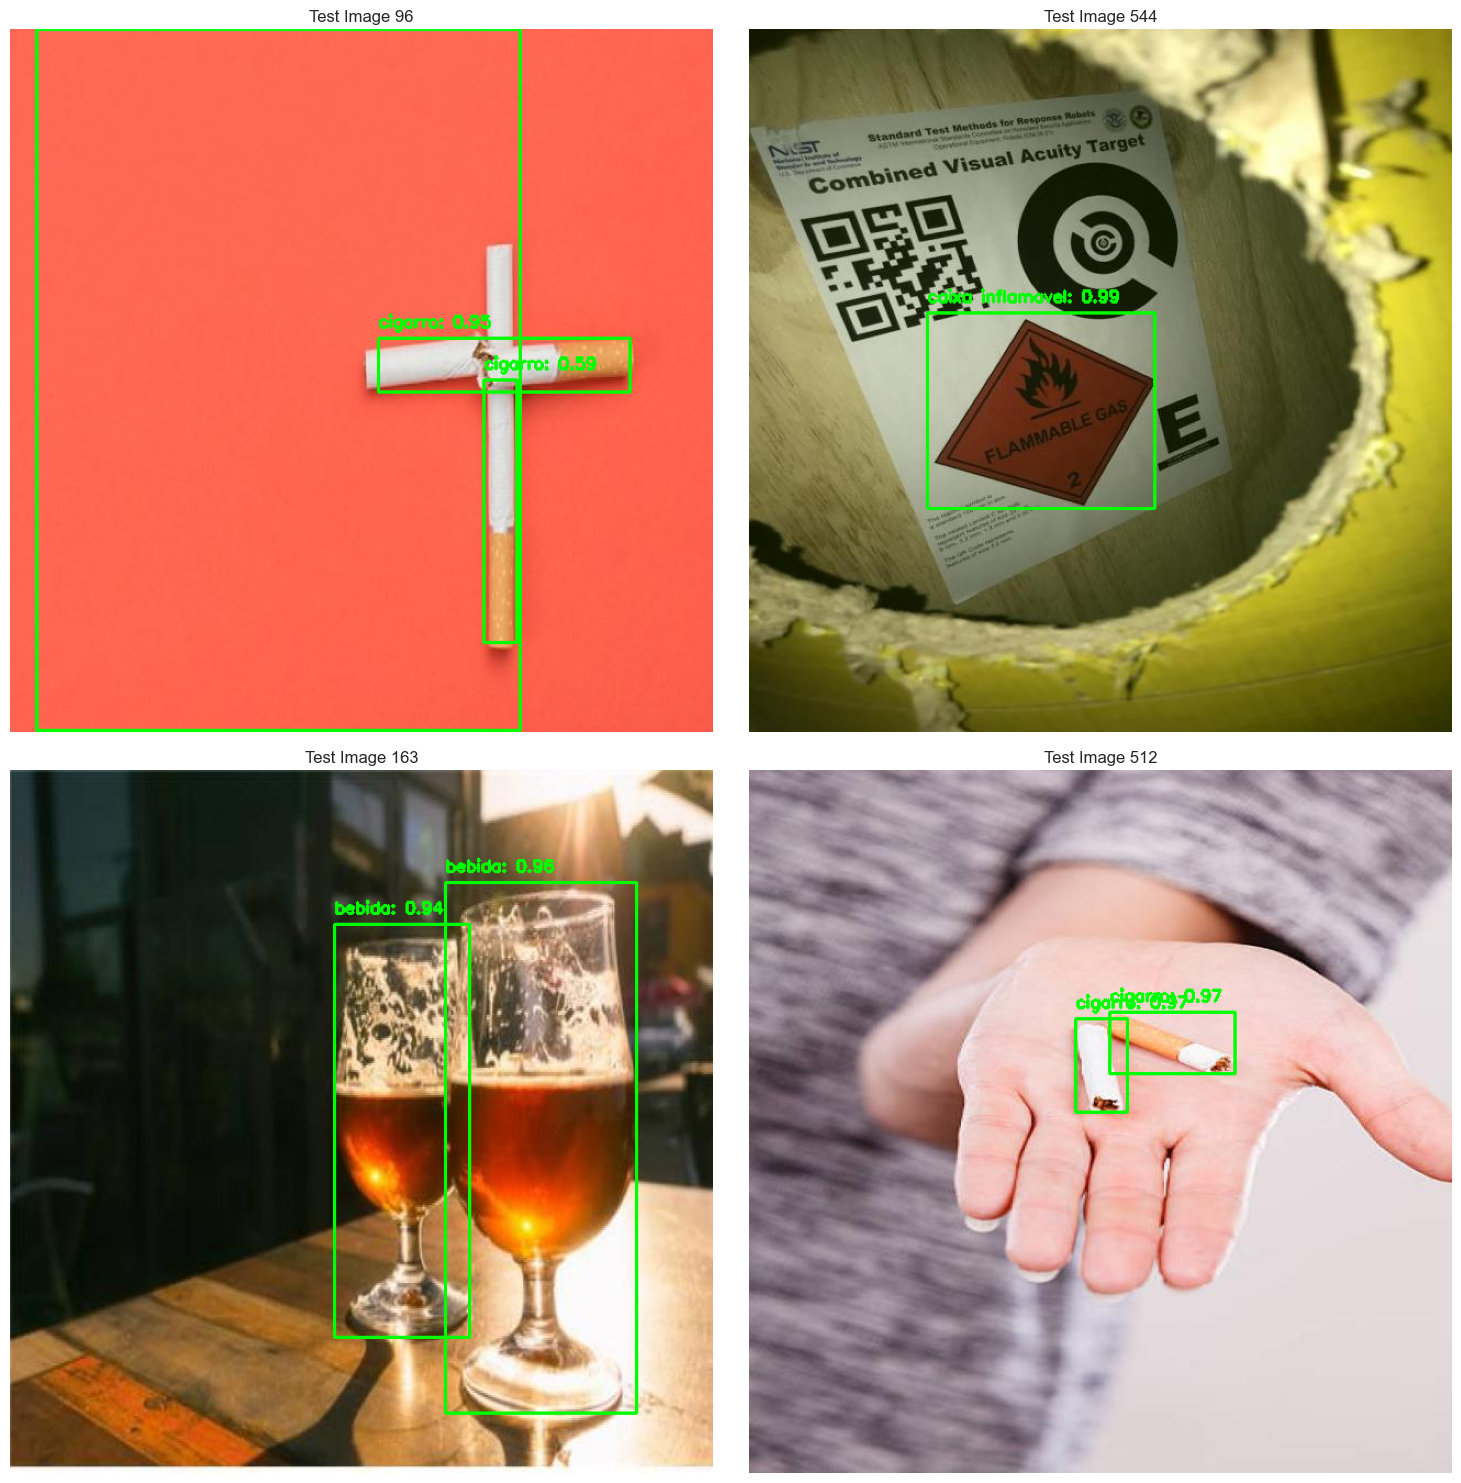

In [32]:
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()

# --- CORREÇÃO AQUI ---
# Usamos a fonte da verdade do COCO API em vez da lista do Roboflow
coco_categories = dataset_test.coco.cats
id_to_class = {cat['id']: cat['name'] for cat in coco_categories.values()}
print("ID Map Real:", id_to_class)
# ---------------------

def visualize_prediction(image, prediction, threshold=0.5):
    # Converte tensor imagem para numpy (H, W, C) e escala para 0-255
    img_copy = image.mul(255).permute(1, 2, 0).byte().cpu().numpy().copy()
    # Converte de RGB (PyTorch) para BGR (OpenCV) para desenhar correto, depois volta
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
    
    for i, box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].item()
        if score > threshold:
            box = box.cpu().numpy().astype(int)
            label_id = prediction[0]['labels'][i].item()
            
            # Pega o nome correto usando o ID retornado pelo modelo
            class_name = id_to_class.get(label_id, f'Unknown ID {label_id}')
            
            label = f'{class_name}: {score:.2f}'
            
            # Desenha retângulo e texto
            cv2.rectangle(img_copy, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
            cv2.putText(img_copy, label, (box[0], box[1] - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

# Seleciona 4 imagens aleatórias
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for i, ax in enumerate(axs.ravel()):
    # Pega imagem do dataset de teste
    idx = random.randint(0, len(dataset_test) - 1)
    img, _ = dataset_test[idx]
    
    with torch.no_grad():
        prediction = model([img.to(device)])
    
    vis_img = visualize_prediction(img, prediction, threshold=0.5)
    ax.imshow(vis_img)
    ax.set_title(f'Test Image {idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Dados encontrados na memória. Total de épocas registradas: 46


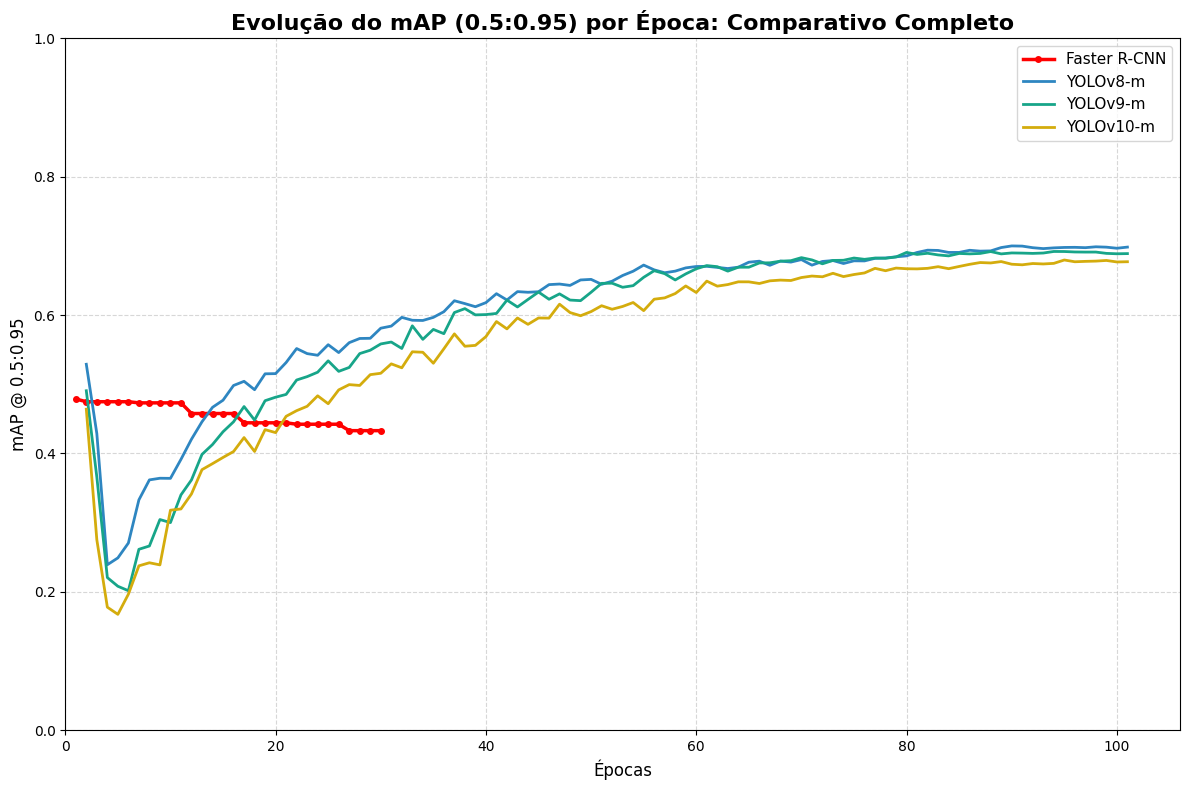

Gráfico salvo como 'comparacao_historico_map.png'


In [19]:
##FAZER A IMAGEM DOS GRAFIOS DE COMPARACAO
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==============================================================================
# 1. CONFIGURAÇÃO DOS DADOS
# ==============================================================================

# A) DADOS DO FASTER R-CNN (Do seu histórico em memória)
# Se você já rodou o treino, a variável 'history' já existe.
# Caso contrário, preencha manualmente a lista abaixo com os valores do log.
if 'history' in locals():
    print(f"Dados encontrados na memória. Total de épocas registradas: {len(history['val_map'])}")
    
    # PEGAR APENAS AS ÚLTIMAS 30 ÉPOCAS (Assumindo que o treino final foi o último)
    # Se preferir as primeiras 30, use [:30]
    frcnn_map_50_95 = history['val_map'][-30:] 
    
    # Recria o eixo X de 1 a 30
    frcnn_epochs = range(1, 31) 
else:
    print("Variável history não encontrada.")
    frcnn_map_50_95 = []
    frcnn_epochs = []

# B) DADOS DOS YOLOS (Lendo dos arquivos results.csv)
# Ajuste os caminhos abaixo para onde seus arquivos results.csv estão salvos
yolo_paths = {
    'YOLOv8-m': 'Benchmark_Visao/Run_YOLOv8/results.csv',   # Ex: 'Benchmark_Visao/Run_YOLOv8/results.csv'
    'YOLOv9-m': 'Benchmark_Visao/Run_YOLOv9/results.csv',
    'YOLOv10-m': 'Benchmark_Visao/Run_YOLOv10/results.csv'
}

# Cores para o gráfico
colors = {
    'Faster R-CNN': 'red',
    'YOLOv8-m': '#2E86C1',  # Azul
    'YOLOv9-m': '#17A589',  # Verde
    'YOLOv10-m': '#D4AC0D'  # Amarelo/Dourado
}

# ==============================================================================
# 2. PROCESSAMENTO E PLOTAGEM
# ==============================================================================
plt.figure(figsize=(12, 8))

# --- Plotar Faster R-CNN ---
plt.plot(frcnn_epochs, frcnn_map_50_95, label='Faster R-CNN', color=colors['Faster R-CNN'], 
         linewidth=2.5, marker='o', markersize=4)

# --- Plotar YOLOs ---
for model_name, csv_path in yolo_paths.items():
    if os.path.exists(csv_path):
        try:
            # O YOLO gera CSVs com espaços nos nomes das colunas, ex: "   metrics/mAP50-95(B)"
            df = pd.read_csv(csv_path)
            
            # Limpa espaços em branco dos nomes das colunas
            df.columns = [c.strip() for c in df.columns]
            
            # Identifica a coluna correta (pode variar levemente entre versões)
            map_col = [c for c in df.columns if 'mAP50-95' in c][0]
            
            # O YOLO loga a epoch, mas às vezes começa do 0. Vamos garantir o eixo X correto.
            epochs = df['epoch'] + 1 if 'epoch' in df.columns else range(1, len(df) + 1)
            
            plt.plot(epochs, df[map_col], label=model_name, color=colors[model_name], linewidth=2)
            
        except Exception as e:
            print(f"Erro ao ler {model_name} em {csv_path}: {e}")
    else:
        print(f"Arquivo não encontrado para {model_name}: {csv_path}. Linha ignorada.")

# ==============================================================================
# 3. ESTILIZAÇÃO FINAL
# ==============================================================================
plt.title('Evolução do mAP (0.5:0.95) por Época: Comparativo Completo', fontsize=16, fontweight='bold')
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('mAP @ 0.5:0.95', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.xlim(left=0)
plt.ylim(0, 1.0) # Assume que mAP vai de 0 a 1

plt.tight_layout()
plt.savefig('comparacao_historico_map.png', dpi=300)
plt.show()

print("Gráfico salvo como 'comparacao_historico_map.png'")